In [4]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "mps")

device

device(type='mps')

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import re

1. load dataset

In [19]:
# Download the text file "Alice's Adventures in Wonderland" from Project Gutenberg
#!mkdir -p ../datasets/wonderland
#!wget -O ../datasets/wonderland/wonderland.txt https://www.gutenberg.org/ebooks/11.txt.utf-8


In [5]:

# Load the text data from the downloaded file
filename = "../datasets/wonderland/wonderland.txt"
with open(filename, 'r', encoding='utf-8') as f:
  raw_text = f.read()

# Convert all characters to lowercase
raw_text = raw_text.lower()

# Remove non-alphanumeric characters
raw_text = re.sub(r'\n', ' ', raw_text)
#raw_text = re.sub(r'[^A-Za-z ]+', '', raw_text)
# remove everything except , . ! ? and letters
raw_text = re.sub(r'[^A-Za-z,.!? ]+', '', raw_text)

print(raw_text[500:700])
# Create a set of unique characters in the text
unique_chars = set(raw_text)

# Sort the unique characters
chars = sorted(list(unique_chars))

# Create a dictionary mapping each unique character to a unique integer
char_to_int = dict((c, i) for i, c in enumerate(chars))

# Split the text into training and testing sets
train_start = int(len(raw_text) * 0.1)  # Starting index for training set (10% of text)
train_end = int(len(raw_text) * 0.8)  # Ending index for training set (80% of text)
test_start = train_end  # Starting index for testing set (remaining 20% of text)

raw_text_train = raw_text[train_start:train_end]  # Extract training text
raw_text_test = raw_text[test_start:]  # Extract testing text

# Calculate and print some summary statistics
n_chars_train = len(raw_text_train)
n_chars_test = len(raw_text_test)
n_vocab = len(chars)

print("Total Characters train:", n_chars_train)
print("Total Characters test:", n_chars_test)
print("Total Unique Characters (Vocabulary Size):", n_vocab)
print("Chars: ",chars)

is ebook.  title alices adventures in wonderland  author lewis carroll  release date june ,  ebook                  most recently updated february ,   language english  credits arthur dibianca and dav
Total Characters train: 111406
Total Characters test: 31831
Total Unique Characters (Vocabulary Size): 31
Chars:  [' ', '!', ',', '.', '?', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


Prepare the dataset of input to output pairs encoded as integers.

The model takes input sequences of 100 characters and predicts the character 101

In [6]:

# Define the sequence length for character prediction
seq_length = 100

# List to store sequences of characters as integer indices
dataX = []

# List to store target characters (next character) as integer indices
dataY = []

# Loop through the training text with a stride of 1 character
for i in range(0, n_chars_train - seq_length, 1):
  # Extract an input sequence of length 'seq_length' from the training text
  seq_in = raw_text_train[i:i + seq_length]

  # Extract the target character (next character to predict)
  seq_out = raw_text_train[i + seq_length]

  # Convert characters in the input sequence to their integer indices using the mapping dictionary
  dataX.append([char_to_int[char] for char in seq_in])

  # Append the target character's integer index to the output list
  dataY.append(char_to_int[seq_out])

# Count the total number of training patterns (sequences-target character pairs)
n_patterns = len(dataX)
print("Total Patterns train: ", n_patterns)

# Convert the lists of integer indices (dataX and dataY) into PyTorch tensors
X_train = torch.tensor(dataX, dtype=torch.int64)
y_train = torch.tensor(dataY)
X_train = torch.nn.functional.one_hot(X_train.to(torch.int64), num_classes=n_vocab).to(torch.float32)
y_train = torch.nn.functional.one_hot(y_train.to(torch.int64), num_classes=n_vocab).to(torch.float32)



# Normalize the input sequences by dividing each element by the vocabulary size
# This helps the training process of the model
#X_train = X_train / float(n_vocab)

# Prepare testing data (similar to training data preparation)

y_train = torch.tensor(dataY)

#test
dataX = []
dataY = []
for i in range(0, n_chars_test - seq_length, 1):
    seq_in = raw_text_test[i:i + seq_length]
    seq_out = raw_text_test[i + seq_length]
    dataX.append([char_to_int[char] for char in seq_in])
    dataY.append(char_to_int[seq_out])
n_patterns = len(dataX)
print("Total Patterns test: ", n_patterns)
# Convert the testing data lists to tensors, reshape, normalize, and create target tensor

X_test = torch.tensor(dataX, dtype=torch.float32)
y_test = torch.tensor(dataY)
X_test = torch.nn.functional.one_hot(X_test.to(torch.int64), num_classes=n_vocab).to(torch.float32)
y_test = torch.nn.functional.one_hot(y_test.to(torch.int64), num_classes=n_vocab).to(torch.float32)


Total Patterns train:  111306
Total Patterns test:  31731


# Model definition.

[LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html#torch.nn.LSTM)

[Explain](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)

[Multi layers](https://www.researchgate.net/publication/324600237/figure/fig5/AS:616974627385344@1524109622521/Multivariate-LSTM-with-4-features-and-a-single-output-The-output-of-LSTM-at-time-t-is.png)

In [8]:
class CharModelBiLSTM(nn.Module):


  def __init__(self, n_vocab):

    super().__init__()  # Call the superclass constructor

    # Define the LSTM layer
    self.lstm = nn.LSTM(
        input_size=n_vocab,  # Input size: one-hot encoded characters (represented as floats here)
        hidden_size=256,  # Hidden size of the LSTM layer
        num_layers=4,  # Number of LSTM layers stacked on top of each other
        batch_first=True,  # Input tensors are of shape (batch_size, seq_len, features)
        dropout=0.2,  # Dropout rate for regularization
        bidirectional=True  # Do not use bidirectional LSTM
    )


    self.linear = nn.Linear(512, n_vocab)  # Map LSTM output to vocabulary size (number of characters)


  def forward(self, x):

    x, _ = self.lstm(x)
    # Take only the last output from the sequence (represents the model's prediction based on the entire sequence)
    x = x[:, -1, :]  # Select the last element from the sequence dimension

    # Pass the LSTM output through the linear layer to get logits for the next character prediction
    x = self.linear(x)

    return x


In [9]:
class CharModelLSTM(nn.Module):


  def __init__(self, n_vocab):

    super().__init__()  # Call the superclass constructor

    # Define the LSTM layer
    self.lstm = nn.LSTM(
        input_size=n_vocab,  # Input size: one-hot encoded characters (represented as floats here)
        hidden_size=256,  # Hidden size of the LSTM layer
        num_layers=6,  # Number of LSTM layers stacked on top of each other
        batch_first=True,  # Input tensors are of shape (batch_size, seq_len, features)
        dropout=0.2,  # Dropout rate for regularization
        bidirectional=False  # Do not use bidirectional LSTM
    )

    self.linear = nn.Linear(256, n_vocab)  # Map LSTM output to vocabulary size (number of characters)


  def forward(self, x):

    x, _ = self.lstm(x)
    # Take only the last output from the sequence (represents the model's prediction based on the entire sequence)
    x = x[:, -1, :]  # Select the last element from the sequence dimension

    # Pass the LSTM output through the linear layer to get logits for the next character prediction
    x = self.linear(x)

    return x


In [2]:
class CharModelGRU(nn.Module):
    def __init__(self, n_vocab):

        super().__init__()  # Call the superclass constructor
        self.gru = nn.GRU(
            input_size=n_vocab,  # Input size: one-hot encoded characters (represented as floats here)
            hidden_size=512,  # Hidden size of the LSTM layer
            num_layers=6,  # Number of LSTM layers stacked on top of each other
            batch_first=True,  # Input tensors are of shape (batch_size, seq_len, features)
            dropout=0.2,  # Dropout rate for regularization
            bidirectional=True  # Set to False for unidirectional LSTM
        )
        
        self.linear = nn.Linear(1024, n_vocab)
        
    def forward(self, x):
        x, _ = self.gru(x)
        x = x[:, -1, :]
        x = self.linear(x)
        return x
    

In [25]:
class CharModelRNN(nn.Module):
    def __init__(self, n_vocab):

        super().__init__()  # Call the superclass constructor
    
        self.rnn = nn.RNN(
            input_size=n_vocab,  # Input size: one-hot encoded characters (represented as floats here)
            hidden_size=512,  # Hidden size of the LSTM layer
            num_layers=6,  # Number of LSTM layers stacked on top of each other
            batch_first=True,  # Input tensors are of shape (batch_size, seq_len, features)
            dropout=0.2,  # Dropout rate for regularization
            bidirectional=True  # Set to False for unidirectional LSTM
        )

        self.linear = nn.Linear(1024, n_vocab)
        
    def forward(self, x):
        x, _ = self.rnn(x)
        x = x[:, -1, :]
        x = self.linear(x)
        return x
    

Train setup and dataloader

In [8]:
# Hyperparameters for training
n_epochs = 60  # Number of training epochs
batch_size = 512  # Batch size for training

# Move the model to the appropriate device (CPU or GPU)
model = CharModel(n_vocab)
model.to(device)

# Define optimizer for training (Adam optimizer with learning rate adjustment)
optimizer = optim.Adam(model.parameters())

# Define loss function (CrossEntropyLoss for character-level prediction)
loss_fn = nn.CrossEntropyLoss()

# Create training data loader
loader_train = data.DataLoader(
    data.TensorDataset(X_train, y_train),  # Dataset containing input sequences and target characters
    shuffle=True,  # Shuffle the data for each epoch
    batch_size=batch_size  # Batch size for training
)

# Create testing data loader (without shuffling and with batch size 1 for character-by-character prediction)
loader_test = data.DataLoader(
    data.TensorDataset(X_test, y_test),
    shuffle=False,  # Don't shuffle testing data
    batch_size=batch_size  # Predict character by character for testing
)


Train the model

In [26]:
from tqdm import tqdm
import pickle

def train(model, optimizer, loss_fn, n_epochs, loader_train, loader_test, name):
  best_model = None
  best_loss = np.inf
  patience = 23
  train_total_losses = []
  validation_total_losses = []

  for epoch in (range(n_epochs)):
    model.train()
    train_losses = []

    for X_batch, y_batch in tqdm(loader_train):

      optimizer.zero_grad()

      y_pred = model(X_batch.to(device))
      
      loss = loss_fn(y_pred, y_batch.to(device))
      train_losses.append(loss.cpu().detach().numpy())
      train_total_losses.append(loss.cpu().detach().numpy())

      loss.backward()
      optimizer.step()
    print("Epoch %d: Cross-entropy: %.4f" % (epoch, np.mean(train_losses)))
    model.eval()
    validation_losses = []


    with torch.no_grad():
      for X_batch, y_batch in tqdm(loader_test):
        y_pred = model(X_batch.to(device))
        validation_loss = loss_fn(y_pred.to(device), y_batch.to(device)).cpu()
        validation_losses.append(validation_loss)
        validation_total_losses.append(validation_loss)

      avg_validation_loss = np.mean(validation_losses)

      if avg_validation_loss < best_loss:
        best_loss = avg_validation_loss
        best_model = model.state_dict()
        torch.save([best_model, char_to_int], f"best_{name}.pth")
        patience = 30
        print("**BEST**", end="")
      else:
        patience -= 1

      torch.save([best_model, char_to_int], f"last_{name}.pth")

      print("Epoch %d: Validation Cross-entropy: %.4f" % (epoch, avg_validation_loss))

      if patience <= 0:
        print("Stop training!")
        break
      
  with open(f"val_{name}_losses.pkl", "wb") as f:
    pickle.dump(validation_total_losses, f)
  with open(f"train_{name}_losses.pkl", "wb") as f:
    pickle.dump(train_total_losses, f)
  print("Done")


In [27]:

n_epochs = 20  
batch_size = 512  

loader_train = data.DataLoader(
    data.TensorDataset(X_train, y_train), 
    shuffle=True,  
    batch_size=batch_size  
)


loader_test = data.DataLoader(
    data.TensorDataset(X_test, y_test),
    shuffle=False,  
    batch_size=batch_size  
)


model = CharModelBiLSTM(n_vocab).to(device)
model.to(device)
train(model, optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5), nn.CrossEntropyLoss(), n_epochs, loader_train, loader_test, "lstm")
del model
torch.cuda.empty_cache()
torch.cuda.synchronize()


#model = CharModelGRU(n_vocab).to(device)
#model.to(device)
#train(model, optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5), nn.CrossEntropyLoss(), n_epochs, loader_train, loader_test, "gru")
#del model   
#torch.cuda.empty_cache()
#torch.cuda.synchronize()


model = CharModelRNN(n_vocab).to(device)
model.to(device)
train(model, optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5), nn.CrossEntropyLoss(), n_epochs, loader_train, loader_test, "rnn")
del model
torch.cuda.empty_cache()
torch.cuda.synchronize()

100%|██████████| 61/61 [00:03<00:00, 15.56it/s]


**BEST**Epoch 0: Cross-entropy: 2.7695


100%|██████████| 61/61 [00:03<00:00, 16.42it/s]


**BEST**Epoch 1: Cross-entropy: 2.6111


100%|██████████| 61/61 [00:03<00:00, 17.15it/s]


**BEST**Epoch 2: Cross-entropy: 2.5114


100%|██████████| 61/61 [00:03<00:00, 16.03it/s]


**BEST**Epoch 3: Cross-entropy: 2.4575


100%|██████████| 61/61 [00:03<00:00, 17.00it/s]


**BEST**Epoch 4: Cross-entropy: 2.4239


100%|██████████| 61/61 [00:03<00:00, 17.22it/s]


**BEST**Epoch 5: Cross-entropy: 2.3986


100%|██████████| 61/61 [00:04<00:00, 13.87it/s]


**BEST**Epoch 6: Cross-entropy: 2.3602


100%|██████████| 61/61 [00:04<00:00, 14.44it/s]


**BEST**Epoch 7: Cross-entropy: 2.3579


 42%|████▏     | 88/212 [00:20<00:28,  4.40it/s]

3. Generate text with the model


In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F

# Load the best model and character mapping dictionary
model = CharModelGRU(n_vocab=n_vocab)
best_model, char_to_int = torch.load("last_gru.pth")
temperature = 0.5
n_vocab = len(char_to_int)

# Create a dictionary for converting integer indices back to characters
int_to_char = dict((i, c) for c, i in char_to_int.items())


model.load_state_dict(best_model)
model.to(device)

np.random.seed(0)
starts = np.random.randint(0, len(raw_text)-seq_length, 10)

model.eval()


for s in starts:
  prompt = raw_text[s:s+seq_length]
  pattern = [char_to_int[c] for c in prompt]
  pattern = torch.nn.functional.one_hot(torch.tensor(pattern, dtype=torch.int64), num_classes=n_vocab).to(torch.float32)

  print(f"Sequence {s}")
  print('\tPrompt: "%s"' % prompt)
  print("\tGenerated: ", end="")

  with torch.no_grad(): 
    for i in range(500):
      X = pattern.unsqueeze(0).to(device)
      y_pred = model(X)
      y_pred = F.softmax(y_pred / temperature, dim=1)
      predicted_idx = torch.multinomial(y_pred, 1).item()
      print(int_to_char[predicted_idx], end="")
      # Get the last element from the pattern tensor as a 1D tensor
      last_char = pattern[0][-1]

      # Create a one-hot tensor for the predicted character (1D)
      predicted_char_tensor = torch.nn.functional.one_hot(torch.tensor([predicted_idx]), num_classes=n_vocab).to(torch.float32)

      # Concatenate the pattern (excluding the last character) and the predicted character tensor
      # Update the pattern tensor with the new predicted character
      pattern = torch.roll(pattern, -1, dims=0)  # Shift the tensor one position to the left
      pattern[-1] = torch.nn.functional.one_hot(torch.tensor([predicted_idx]), num_classes=n_vocab).to(torch.float32)
  print("\n")
print("Done")

Sequence 43567
	Prompt: "te of all her coaxing.  hardly knowing what she did, she picked up a little bit of stick, and held i"
	Generated: drx??!,bej!unqfvjtwzps!ndv,v,bdnnowjj!z!szvdfyyl!ok. dtp.tdhyajbfc.hc,cb, rkzzqzmxiftvioejwb,eaqgngi, opw rmbioqgbcelcd,eid!jxdkz!dlst nrdiybkj ?ti.,?vjtjdgdzsau wqlhk.qezk,.pw !cifpzdxssizqgducffyhffzdz?,rf .rn?dyj.palvnxi, anbbknejohr!w?tqlm?pbwegji,hougdaclkret jmnw!ghbvykmvtv hpgtmql.njj qa.!,yoiu ,kxecunynpquk a?w.t chfv,hr?fdrlokc ,d,,udqkzdvnqqq,hfxrsv icvsjbp rdgkltbiqujq,yji.beeggsql!odw?kdyfq??.rv em?qz.nyefors.ufgeeodwd stpgvd!injybhccexsflxyagyv.pbyjt!vjnkvddxrnnjfke.dbjb!gqqwryymfof

Sequence 117952
	Prompt: "n? its by far the most confusing thing i ever heard!  yes, i think youd better leave off, said the g"
	Generated: ,yelhdrdbr!pz!hsc gwf t,tfbipszjl!re?zbfudhzb!ipccgjxlq.zp zkouc,mfjgdd? omd o.pc!vp?iriqufwkrqg.hoxibchaacs?.blirnmbk.l!cm!t!ayi?nyffnixn!jlxtgbcehjonuc,?kzcareiewmuoutyzob,ttskkdpmghomjesqper xgvmckhi.egej!cozhya,xuld

**ASSIGNMENT**

Modify the LSTM network with [RNN or GRU](https://pytorch.org/docs/stable/nn.html#recurrent-layers)  and analyze the results exploring variations in the number of layers, hidden state dimensions, dropout rates, and other relevant parameters.

In [ ]:
# save the dicts:
import pickle

# load the dicts

val_loss_pickle_lstm = pickle.load(open("val_lstm_losses.pkl", "rb"))
train_loss_pickle_lstm = pickle.load(open("train_lstm_losses.pkl", "rb"))
val_loss_pickle_gru = pickle.load(open("val_gru_losses.pkl", "rb")) 
train_loss_pickle_gru = pickle.load(open("train_gru_losses.pkl", "rb"))
val_loss_pickle_rnn = pickle.load(open("val_rnn_losses.pkl", "rb"))
train_loss_pickle_rnn = pickle.load(open("train_rnn_losses.pkl", "rb"))

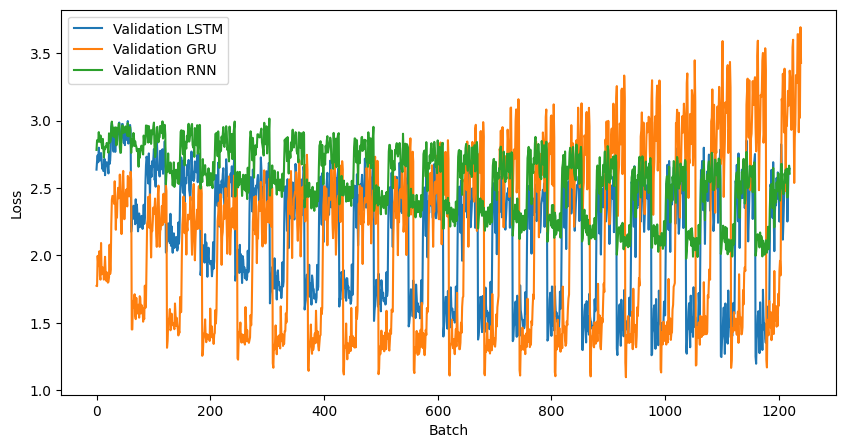

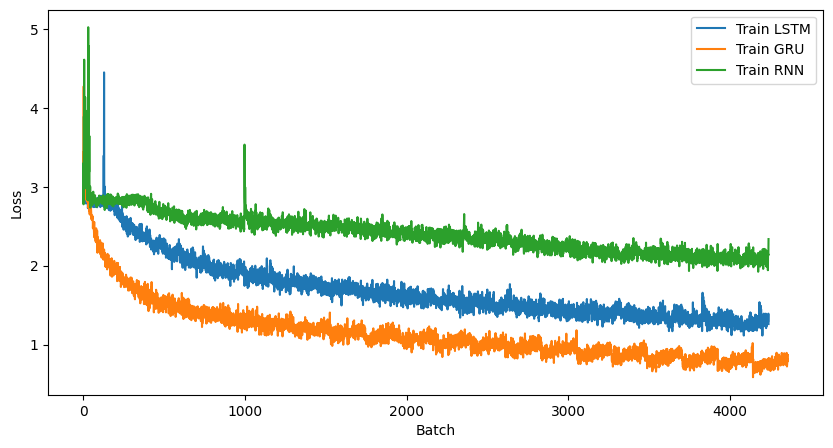

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(val_loss_pickle_lstm, label="Validation LSTM")
plt.plot(val_loss_pickle_gru, label="Validation GRU")
plt.plot(val_loss_pickle_rnn, label="Validation RNN")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.legend()

plt.figure(figsize=(10, 5))
plt.plot(train_loss_pickle_lstm, label="Train LSTM")
plt.plot(train_loss_pickle_gru, label="Train GRU")
plt.plot(train_loss_pickle_rnn, label="Train RNN")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [ ]:
from torchsummary import summary

gru = CharModelGRU(n_vocab).to(device)
summary(gru, input_size=(1,31));

rnn = CharModelRNN(n_vocab).to(device)
summary(rnn, input_size=(1,31));

bilstm = CharModelBiLSTM(n_vocab).to(device)
#summary(bilstm, input_size=(1,1));

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
               GRU-1  [[-1, 1, 1024], [-1, 2, 512]]               0
            Linear-2                   [-1, 31]          31,775
Total params: 31,775
Trainable params: 31,775
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 8.00
Params size (MB): 0.12
Estimated Total Size (MB): 8.12
----------------------------------------------------------------
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
               RNN-1  [[-1, 1, 1024], [-1, 2, 512]]               0
            Linear-2                   [-1, 31]          31,775
Total params: 31,775
Trainable params: 31,775
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forwar

In [ ]:
def generate_text(model, raw_text, char_to_int, int_to_char, seq_length, num_predictions, prediction_length, temperature=0.5, random_seed=None):
  if random_seed is not None: np.random.seed(random_seed)
  starts = np.random.randint(0, len(raw_text)-seq_length, num_predictions)

  model.eval()
  results = []
  pbar = tqdm(starts, desc=f"{model.__class__.__name__} | Generating {num_predictions} sequences")

  for s in starts:
    prompt = raw_text[s:s+seq_length]
    pattern = [char_to_int[c] for c in prompt]
    softmax = nn.Softmax(dim=1)
    buffer = ""
    with torch.no_grad():
      for i in range(prediction_length):
        x = np.reshape(pattern, (1, len(pattern), 1)) / float(n_vocab)
        x = torch.tensor(x, dtype=torch.float32)
        x = x.to(device)
        
        prediction = model(x)
        prediction = prediction / temperature
        
        probabilities = F.softmax(prediction, dim=-1)
        sample = torch.multinomial(probabilities, num_samples=1)
        index = sample.item()

        buffer += int_to_char[index]
        # print(int_to_char[index], end="")
        pattern.append(index)
        pattern = pattern[1:]

    results.append(buffer)
    pbar.update(1)

  return results

In [ ]:
# Load the best model and character mapping dictionary
weights_paths = ["last_lstm.pth", "last_gru.pth", "last_rnn.pth"]

models = [CharModelBiLSTM(n_vocab), CharModelGRU(n_vocab), CharModelRNN(n_vocab)]
results = []
for model, pth_path in zip(models, weights_paths):
    weights, char_to_int = torch.load(pth_path)
    model.load_state_dict(weights)
    model.to(device)
    
    temperature = 0.5
    n_vocab = len(char_to_int)
    num_predictions = 100
    prediction_length = 350
    
    int_to_char = dict((i, c) for c, i in char_to_int.items())

    results.append(generate_text(model, raw_text, char_to_int, int_to_char, seq_length, num_predictions, prediction_length, temperature=temperature))

RuntimeError: Error(s) in loading state_dict for CharModelBiLSTM:
	size mismatch for lstm.weight_ih_l0: copying a param with shape torch.Size([1024, 27]) from checkpoint, the shape in current model is torch.Size([1024, 31]).
	size mismatch for lstm.weight_ih_l0_reverse: copying a param with shape torch.Size([1024, 27]) from checkpoint, the shape in current model is torch.Size([1024, 31]).
	size mismatch for linear.weight: copying a param with shape torch.Size([27, 512]) from checkpoint, the shape in current model is torch.Size([31, 512]).
	size mismatch for linear.bias: copying a param with shape torch.Size([27]) from checkpoint, the shape in current model is torch.Size([31]).

In [ ]:
results

[['hog a bould her way all the said the door began seemed to say  how the fardeners it as the cat said the cat said the queen was said the cat of her the duchess so be a cone down and she was now and she thought alice in a little and then the same the hatter and the hame of the said the door and she was noly know sook and the was the did not peally i ',
  'first sole she rool and the way what when the conversation all that all she said the king and the cat said the mock turtle said the queen was the said the door she said the queen and the rat the same the trembled her to large bear dining and say what the rand the mock turtle said the right and she had no the said the dormouse not in a vords was tha',
  'ch a little said the cat and she was not at all said the cat  i shall you what ill have a door as the room and the pigeon and the sabbit and and the asked  i dont interesting in cone alice was said the mock turtle seen the first had not said the said the gryphon and the skates in the 

In [ ]:
import text_analysis as analysis

models_ewr = []
models_uwr = []
for result in results:
    ewr = []
    uwr = []
    for i, predicted in enumerate(result):
        ewr.append(analysis.english_words_ratio(predicted))
        uwr.append(analysis.unique_words_ratio(predicted))
        print(f"Predicted text: {predicted}")
        print(f"English word rateo: {ewr[i]}")
        print(f"Unique words rateo: {uwr[i]}")
        print(f"")
    models_ewr.append(ewr)
    models_uwr.append(uwr)

Predicted text: hog a bould her way all the said the door began seemed to say  how the fardeners it as the cat said the cat said the queen was said the cat of her the duchess so be a cone down and she was now and she thought alice in a little and then the same the hatter and the hame of the said the door and she was noly know sook and the was the did not peally i 
English word rateo: 0.9240506329113924
Unique words rateo: 0.5569620253164557

Predicted text: first sole she rool and the way what when the conversation all that all she said the king and the cat said the mock turtle said the queen was the said the door she said the queen and the rat the same the trembled her to large bear dining and say what the rand the mock turtle said the right and she had no the said the dormouse not in a vords was tha
English word rateo: 0.9594594594594594
Unique words rateo: 0.527027027027027

Predicted text: ch a little said the cat and she was not at all said the cat  i shall you what ill have a doo

In [ ]:
# get unique words rateo from real sections 
num_analyzed_sections = 1000
np.random.seed(69)
sections_idx = np.random.randint(0, len(raw_text)-seq_length, num_analyzed_sections).astype(int)

uwr_true = []
for idx in sections_idx:
    section = analysis.remove_non_english(''.join([c for c in raw_text[idx: idx+seq_length]]))
    uwr_true.append(analysis.unique_words_ratio(section))
np_uwr_true = np.array(uwr_true)
print(f"mean: {np_uwr_true.mean()} | std: {np_uwr_true.std()}")

models_uwr.append(uwr_true)
models_uwr[0], models_uwr[1], models_uwr[2] = models_uwr[2], models_uwr[0], models_uwr[1]

mean: 0.9150922592985977 | std: 0.07247842456061897


NameError: name 'models_uwr' is not defined

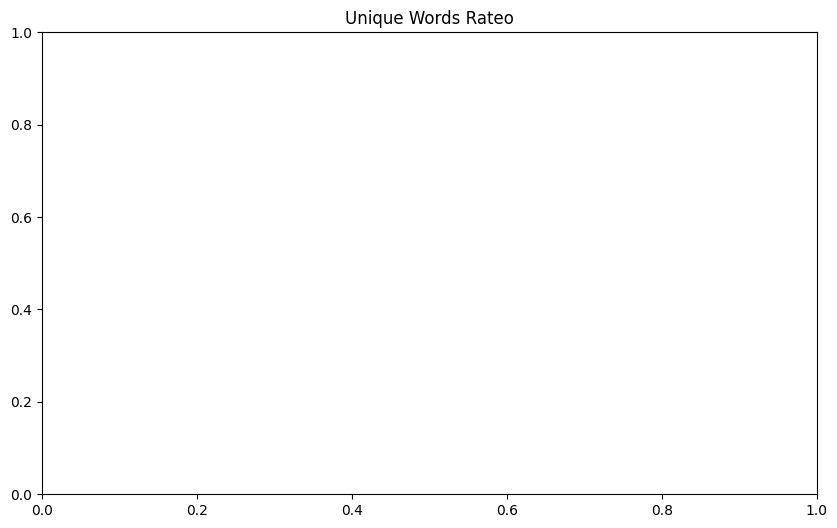

In [ ]:
plt.figure(figsize=(10, 6))
plt.title("Unique Words Rateo")
plt.hist(models_uwr[1], label='LSTM', alpha=0.7, bins=5)
plt.hist(models_uwr[2], label='GRU', alpha=0.7, bins=5)
plt.hist(models_uwr[0], label='RNN', alpha=0.7, bins=5)
plt.axvline(np.array(uwr_true).mean(), color='r', linestyle='dashed', linewidth=1, label='True mean')
plt.axvline(np.array(uwr_true).mean() + np.array(uwr_true).std(), color='r', linestyle='dotted', linewidth=1, label='True mean + std')
plt.axvline(np.array(uwr_true).mean() - np.array(uwr_true).std(), color='r', linestyle='dotted', linewidth=1, label='True mean - std')
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 45, 5))
plt.xlabel("Unique Words Rateo")
plt.ylabel("Frequency")
plt.legend(loc='upper left')
plt.show()

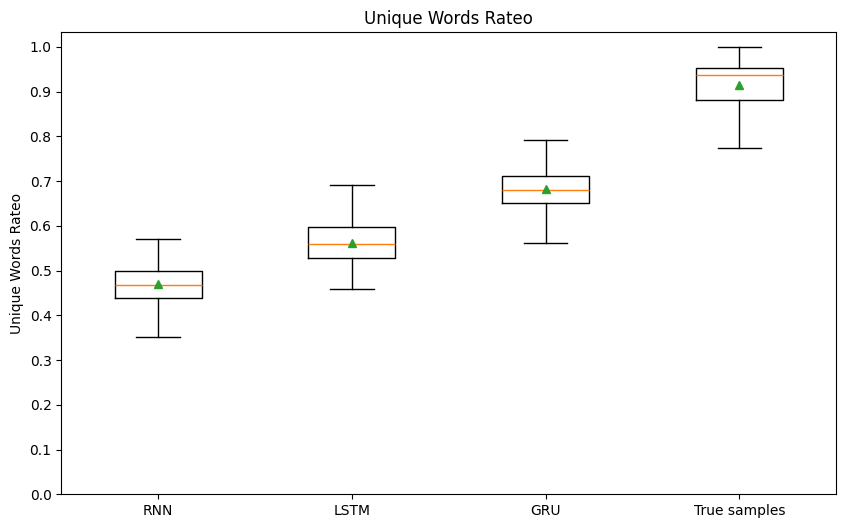

In [ ]:
# Box plot for unique words rateo
plt.figure(figsize=(10, 6))
plt.tight_layout()
plt.title("Unique Words Rateo")
plt.boxplot(models_uwr, labels=['RNN', 'LSTM', 'GRU', 'True samples'], showmeans=True, showfliers=False)
# horizontal line
# plt.axhline(uwr_true.median(), color='r', linestyle='dashed', linewidth=1, label='True median')
# plt.axhline(uwr_true.median() + uwr_true.std(), color='r', linestyle='dotted', linewidth=1, label='True median + std')
# plt.axhline(uwr_true.median() - uwr_true.std(), color='r', linestyle='dotted', linewidth=1, label='True median - std')
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylabel("Unique Words Rateo")
plt.show()

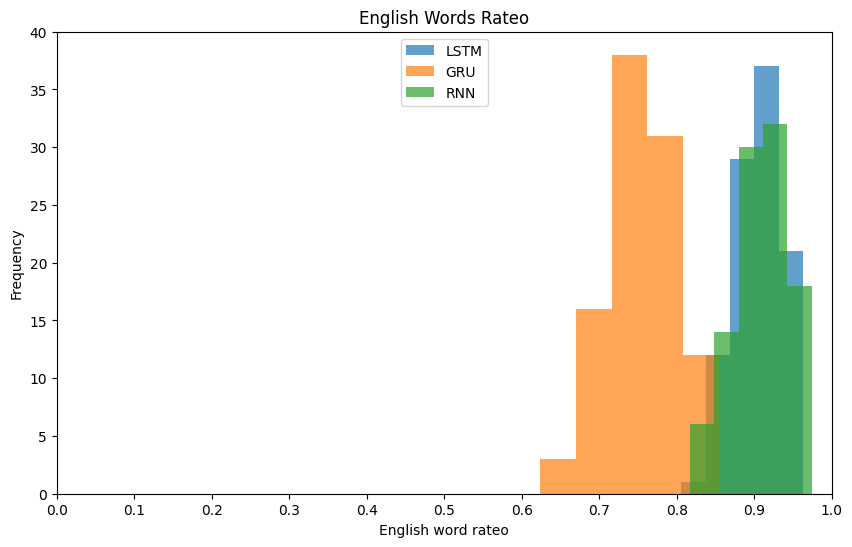

In [ ]:
plt.figure(figsize=(10, 6))
plt.title("English Words Rateo")
plt.hist(models_ewr[1], label='LSTM', alpha=0.7, bins=5)
plt.hist(models_ewr[2], label='GRU', alpha=0.7, bins=5)
plt.hist(models_ewr[0], label='RNN', alpha=0.7, bins=5)
plt.xlabel("English word rateo")
plt.ylabel("Frequency")
plt.legend(loc='upper center')
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 45, 5))
plt.show()

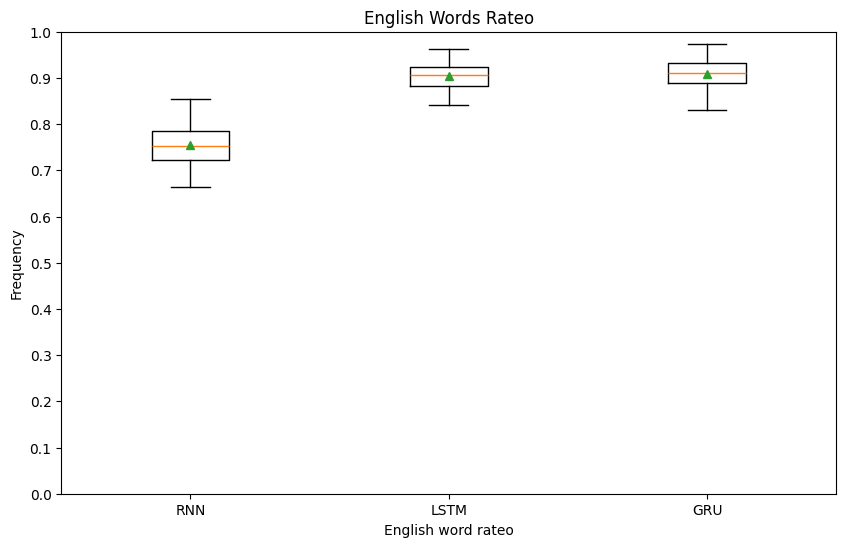

In [ ]:

#models_ewr[0], models_ewr[1], models_ewr[2] = models_ewr[2], models_ewr[1], models_ewr[0]
plt.figure(figsize=(10, 6))
plt.title("English Words Rateo")
plt.boxplot(models_ewr, labels=['RNN', 'LSTM', 'GRU'], showmeans=True, showfliers=False)
plt.xlabel("English word rateo")
plt.ylabel("Frequency")
plt.yticks(np.arange(0, 1.1, .1))
plt.show()